### Problems need to be comfired

1. How to generate M? 
2. Given output of conv4_3 layer, how to generate M_hat?
3. Does selected feature maps indexes are fixed arcoss all imgs in a video?


probel: sel_cnn loss can not decrease
idea1: change scale factor of the mask
idea2: change data

In [40]:
import tensorflow as tf
import numpy as np
import skimage
import skimage.io
import skimage.transform

import matplotlib.pyplot as plt
import scipy.stats as st
import os
import sys

from vgg16 import Vgg16
from sel_CNN import selCNN
from utils import extract_roi, gen_mask, img_with_bbox, print_prob

show = skimage.io.imshow
%matplotlib inline

In [46]:
class f:
    def __init__(self,a):
        print(a + 1)
class c(f):
    def __init__(self,a):
        super(c, self).__init__(a)

i = c(9)

10


In [45]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['inputs',
 'vgg16/images',
 'vgg16/mul/y',
 'vgg16/mul',
 'vgg16/split/split_dim',
 'vgg16/split',
 'vgg16/sub/y',
 'vgg16/sub',
 'vgg16/sub_1/y',
 'vgg16/sub_1',
 'vgg16/sub_2/y',
 'vgg16/sub_2',
 'vgg16/concat/concat_dim',
 'vgg16/concat',
 'vgg16/conv1_1/filter',
 'vgg16/conv1_1/Conv2D',
 'vgg16/conv1_1/bias',
 'vgg16/conv1_1/BiasAdd',
 'vgg16/conv1_1/Relu',
 'vgg16/conv1_2/filter',
 'vgg16/conv1_2/Conv2D',
 'vgg16/conv1_2/bias',
 'vgg16/conv1_2/BiasAdd',
 'vgg16/conv1_2/Relu',
 'vgg16/pool1',
 'vgg16/conv2_1/filter',
 'vgg16/conv2_1/Conv2D',
 'vgg16/conv2_1/bias',
 'vgg16/conv2_1/BiasAdd',
 'vgg16/conv2_1/Relu',
 'vgg16/conv2_2/filter',
 'vgg16/conv2_2/Conv2D',
 'vgg16/conv2_2/bias',
 'vgg16/conv2_2/BiasAdd',
 'vgg16/conv2_2/Relu',
 'vgg16/pool2',
 'vgg16/conv3_1/filter',
 'vgg16/conv3_1/Conv2D',
 'vgg16/conv3_1/bias',
 'vgg16/conv3_1/BiasAdd',
 'vgg16/conv3_1/Relu',
 'vgg16/conv3_2/filter',
 'vgg16/conv3_2/Conv2D',
 'vgg16/conv3_2/bias',
 'vgg16/conv3_2/BiasAdd',
 'vgg16/conv3_2/

In [42]:
graph = tf.get_default_graph()
graph.as_graph_def().node

In [2]:
def porcess_img(img):
    """
    Porcessing image required by vgg16
    Returns:
        image of shape [224, 224, 3]
        [1, height, width, depth]
    """
    # load image
    img = img / 255.0
    assert (0 <= img).all() and (img <= 1.0).all()
    
    # conert to color image if its a grey one
    if len(img.shape) < 3:
        img = skimage.color.gray2rgb(img)
    assert len(img.shape) == 3
    
    # crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy : yy + short_edge, xx : xx + short_edge]

    # resize to 224, 224
    resized_img = skimage.transform.resize(crop_img, (224, 224))
    return resized_img.reshape((1, 224, 224, 3))

def _variable_on_cpu(name, shape, initializer):
	"""Helper to create a Variable stored on CPU memory.

	Args:
	  name: name of the variable
	  shape: list of ints
	  initializer: initializer for Variable

	Returns:
	  Variable Tensor
	"""
	dtype = tf.float32
	with tf.device('/cpu:0'):
		variable = tf.get_variable(name, shape, initializer=initializer, dtype=dtype)
	return variable

def variable_with_weight_decay(name, shape, stddev=1e-3, wd=None):
	"""Helper to create an initialized Variable with weight decay

	Args:
		name: name of the variable
		shape: list of ints
		stddev: float, standard deviation of a truncated Gaussian for initial value
		wd: add L2loss weight decay multiplied by this float. If None, weight decay 
				is not added to this variable

	Returns:
		Variable: Tensor
	"""
	dtype = tf.float32
	variable = _variable_on_cpu(
							name, 
							shape,
							initializer=tf.truncated_normal_initializer(stddev=stddev, dtype=dtype))
	if wd is not None:
		weight_decay = tf.mul(tf.nn.l2_loss(variable), wd, name='weight_loss')
		tf.add_to_collection('losses', weight_decay)
	return variable

def img_porcess(img):
    img = img.astype(float)
    # conert to color image if its a grey one
    if len(img.shape) < 3:
        img = skimage.color.gray2rgb(img)
        
    # Swap x,y order and subtract mean value
    mean_pix = [123.68, 116.779, 103.939] # BGR
    img = np.transpose(img, [1,0,2])
    img[:, :, 0] -= mean_pix[0]
    img[:, :, 1] -= mean_pix[1]
    img[:, :, 2] -= mean_pix[2]
    return img.reshape((1, 224, 224, 3))

In [3]:
data_path = 'data/Dog1/'
img_path = os.path.join(data_path, 'img/0001.jpg')

# read bbox from file 
gt_fn = os.path.join(data_path, 'groundtruth_rect.txt')
f = open(gt_fn, 'r')
lines = f.readlines()

# gt_list is a list of list locations
gt_list = [[int(p) for p in i[:-1].split(',')] #('\t')] 
                   for i in lines]

# parper inputs 
gt_1 = gt_list[0]
img_origin = skimage.io.imread(img_path)

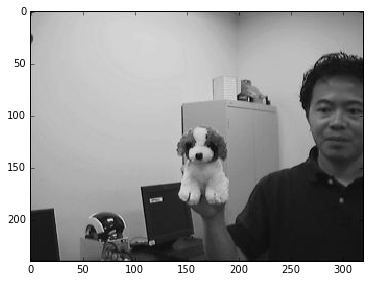

In [4]:
show(img_origin)

233 origin max
218 before bicubic resize
222 after bicubic resize
222 roi max


/home/xlws/repos/FCNT_TF/utils.py:173: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  print(img[y1-1:y2, x1-1:x2, :].max(), 'before bicubic resize')
/home/xlws/repos/FCNT_TF/utils.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [roi_size, roi_size], interp='bicubic')


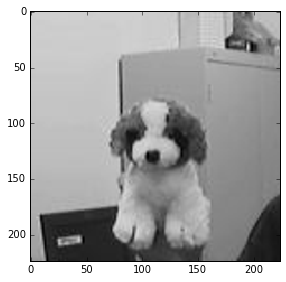

In [5]:

if len(img_origin.shape) < 3:
    img_origin = skimage.color.gray2rgb(img_origin)
assert len(img_origin.shape) == 3

w, h = gt_1[2:]
roi_size = 224
roi_scale = 2
dia = (w**2 + h**2)**0.5
scale = [dia / w, dia / h]
s1 = [roi_scale*scale[0], roi_scale*scale[1]]
roi, roi_pos, preimg, pad = extract_roi(img_origin, gt_1, [0,0], roi_size, s1)
#roi, _,_ =extract_roi_old(img_origin, gt_1, roi_size)
skimage.io.imshow(roi)

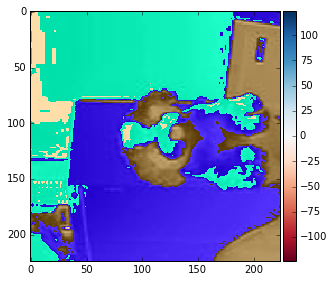

In [6]:
img_porcessed = img_porcess(roi)
show(img_porcessed[0,...])

In [7]:
fea_sz = (28, 28)
mask = gen_mask(img_origin.shape, fea_sz, roi_size, gt_1, [0,0], s1)

0.0013186425201 max of mask
0.0013186425201 origin max
0.0013186425201 before bicubic resize
255 after bicubic resize
255 roi max
(224, 224, 3)
248 max convas


/home/xlws/repos/FCNT_TF/utils.py:173: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  print(img[y1-1:y2, x1-1:x2, :].max(), 'before bicubic resize')
/home/xlws/repos/FCNT_TF/utils.py:174: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  roi =  imresize(img[y1-1:y2, x1-1:x2, :], [roi_size, roi_size], interp='bicubic')


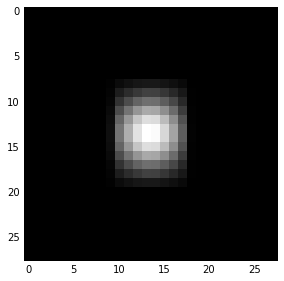

In [8]:
show(mask)

In [9]:
tf.reset_default_graph()

In [10]:

vgg = Vgg16()

sess = tf.Session()
sess.run(tf.initialize_all_variables())

feed_dict = { vgg.inputs: img_porcessed }
prob_tensor = vgg.softmax
prob = sess.run(prob_tensor, feed_dict=feed_dict)
print_prob(prob[0])
sess.close()

prob shape (1000,)
Top1:  n03255030 dumbbell
Top5:  ['n03255030 dumbbell', 'n02790996 barbell', 'n15075141 toilet tissue, toilet paper, bathroom tissue', 'n02317335 starfish, sea star', 'n02389026 sorrel']


/home/xlws/anaconda3/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


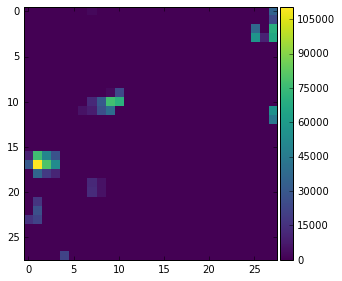

In [11]:
# visual conv layer
with tf.Session() as sess:
    res4, res5 = sess.run([vgg.conv4_3, vgg.conv5_3], feed_dict=feed_dict)
skimage.io.imshow(res4[0,:,:,0])

In [12]:
isinstance(vgg.conv4_3, tf.Tensor)

True

In [13]:

l_selcnn = selCNN('local', vgg.conv4_3)
pre_M_tensor = l_selcnn.pre_M
train_op, losses, lr, optimizer = l_selcnn.train(mask)


sess = tf.Session()
sess.run(tf.initialize_all_variables())




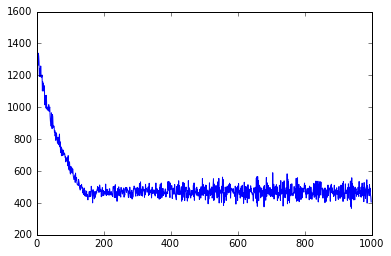

In [14]:
max_itertimes = 1000
loss = []
imgs = []
lrt = []
for i in range(max_itertimes):
    # update weights
    _, total_loss, pre_M, lr_ = sess.run([train_op, losses, pre_M_tensor, lr], feed_dict=feed_dict)
    
    # visualize predicted heat map
    sys.stdout.flush()
    #print('loss: ',total_loss)
    loss.append(total_loss)
    lrt.append(lr_)
    if i % 50==0:
        imgs.append(pre_M)
    #plt.imshow(pre_M[0,:,:,0])
plt.plot(loss)

In [15]:
loss[:10]

[1441.5283,
 1416.8293,
 1291.9023,
 1295.3219,
 1263.5933,
 1338.999,
 1320.2017,
 1282.7354,
 1192.5134,
 1243.66]

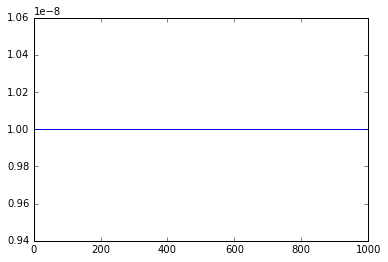

In [16]:
plt.plot(lrt)

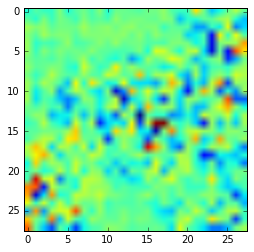

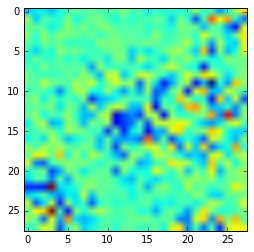

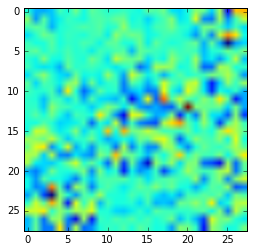

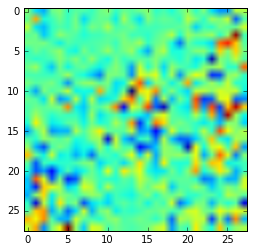

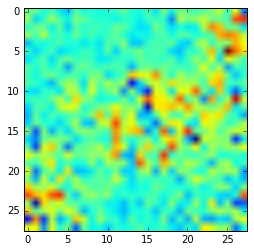

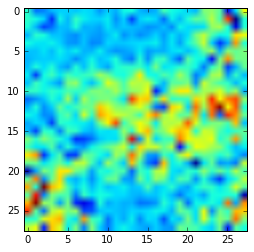

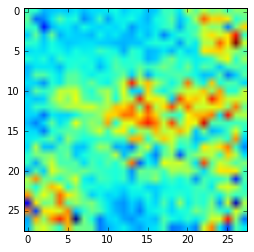

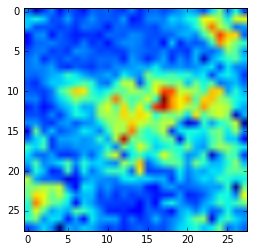

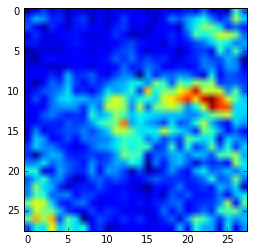

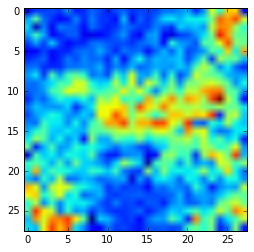

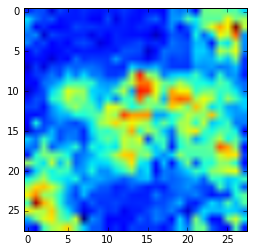

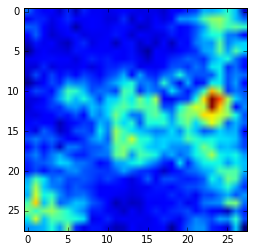

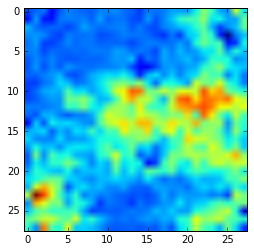

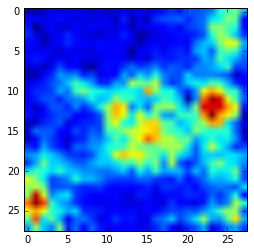

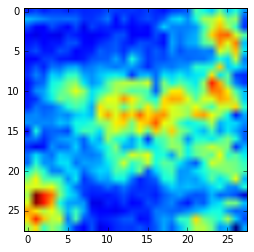

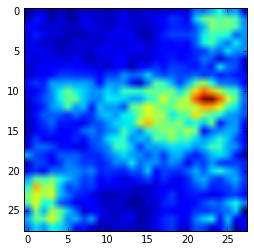

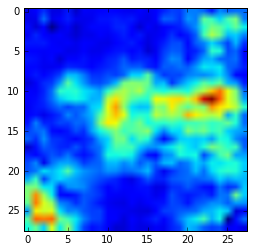

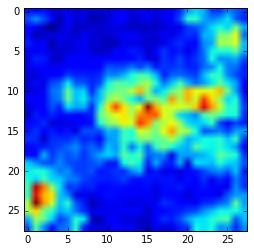

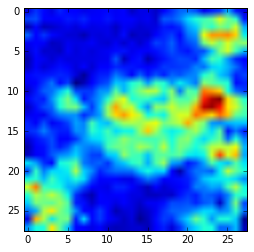

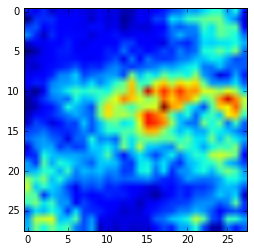

In [17]:
for img in imgs:
    plt.figure()
    plt.imshow(img[0,:,:,0])

In [18]:
loss[-1]

405.91061

## Computes saiency maps

In [20]:
# S = -GF + 0.5 * H * F**2
# where G is partial derivative of L(sel-CNN) with respect to F feature
# maps of vgg. H is a diagnal part of the Hessian matrix, which can be 
# computed by back probpagation twice with respect to the feature maps.



In [21]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

['inputs',
 'vgg16/images',
 'vgg16/mul/y',
 'vgg16/mul',
 'vgg16/split/split_dim',
 'vgg16/split',
 'vgg16/sub/y',
 'vgg16/sub',
 'vgg16/sub_1/y',
 'vgg16/sub_1',
 'vgg16/sub_2/y',
 'vgg16/sub_2',
 'vgg16/concat/concat_dim',
 'vgg16/concat',
 'vgg16/conv1_1/filter',
 'vgg16/conv1_1/Conv2D',
 'vgg16/conv1_1/bias',
 'vgg16/conv1_1/BiasAdd',
 'vgg16/conv1_1/Relu',
 'vgg16/conv1_2/filter',
 'vgg16/conv1_2/Conv2D',
 'vgg16/conv1_2/bias',
 'vgg16/conv1_2/BiasAdd',
 'vgg16/conv1_2/Relu',
 'vgg16/pool1',
 'vgg16/conv2_1/filter',
 'vgg16/conv2_1/Conv2D',
 'vgg16/conv2_1/bias',
 'vgg16/conv2_1/BiasAdd',
 'vgg16/conv2_1/Relu',
 'vgg16/conv2_2/filter',
 'vgg16/conv2_2/Conv2D',
 'vgg16/conv2_2/bias',
 'vgg16/conv2_2/BiasAdd',
 'vgg16/conv2_2/Relu',
 'vgg16/pool2',
 'vgg16/conv3_1/filter',
 'vgg16/conv3_1/Conv2D',
 'vgg16/conv3_1/bias',
 'vgg16/conv3_1/BiasAdd',
 'vgg16/conv3_1/Relu',
 'vgg16/conv3_2/filter',
 'vgg16/conv3_2/Conv2D',
 'vgg16/conv3_2/bias',
 'vgg16/conv3_2/BiasAdd',
 'vgg16/conv3_2/

In [23]:
F = vgg.graph.get_tensor_by_name('vgg16/conv4_3/filter:0')
F = tf.assign(F, tf.Variable(F, trainable=False))
G = optimizer.compute_gradients(losses, var_list=[F])

In [38]:
tt = tf.Variable(F, trainable=False)

In [34]:
g= tf.get_default_graph()

In [39]:
[n.name for n in g.get_collection('variables')]

['local/kernel:0',
 'local/biases:0',
 'Variable:0',
 'Variable_1:0',
 'Variable_2:0',
 'Variable_3:0']

In [33]:
F.

''

In [26]:
F = tf.assign(F, tf.Variable(F, trainable=False))

TypeError: Input 'ref' of 'Assign' Op requires l-value input

In [25]:
G = optimizer.compute_gradients(losses, var_list=[F])

TypeError: Argument is not a tf.Variable: Tensor("vgg16/conv4_3/filter:0", shape=(3, 3, 512, 512), dtype=float32)